Using the data from following table create a model predicting number of passenger deaths. Use poisson distribution in two variants

    1. The rate is constant for all years and not depending on anything.
    2. The intensity is constant, but rate is a product of intensity and miles flown.

Select appropriate priors, perform prior predictive checks, fit the model and using posterior predictive distribution predict the death rates from the model.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

import utilities.stan_utility as stan_utility
import pystan
import matplotlib as mpl

import scipy.stats as stats
from scipy.stats import kde


In [2]:

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200


In [42]:
dts=[24,734,25,516,31,754,31,877,22,814,21,362,26,764,20,809,16,223,22,1066]
c1=dts[::2]
c2=dts[1::2]

Airline_data=pd.DataFrame({'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
'Fatal accidents':c1,  
'Passenger deaths':c2,
'Death rate':[0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]}).set_index('Year')
Airline_data['Miles flown [100 mln miles]']=np.round(Airline_data['Passenger deaths']/Airline_data['Death rate'])

## generation of vector for plotting samples under histograms
dead=[]
dta_cnt=[]
for k in Airline_data['Passenger deaths']:  
    dta_cnt.append(-(1.+dead.count(k)))
    dead.append(k)
dta_cnt=np.array(dta_cnt)

Airline_data

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


For prior I am going to assume, that planes would not be considered a safe mean of transport if there was a big passanger plane accident every month. I am going to assume that a big passanger plane has arround 150 people aboard (which is close to average capacity of Boeing 737, the most popular passanger plane type). Whith that number multiplied by the number of months, we get 1800 deaths yearly. Which is close to two times the highest number recorded in considered database.

For poisson distribution we have mean of $\lambda$ and standard deviation of $\sqrt{\lambda}$. Approximately in order to have no more than 1% probability $\lambda$ should fulfill $$\lambda+3\sqrt{\lambda}\approx1800$$ We need to assign the prior that would have probability of smaller $\lambda$ equal 99%.

In [5]:
root_of_lam=np.polynomial.polynomial.polyroots([-1800.,3.,1.])
lam_ub=np.round(root_of_lam[root_of_lam>0]**2)
print(lam_ub)

[1677.]


Prior tuning in Stan

In [6]:
with open('stan/prior_tune1.stan', 'r') as file:
    print(file.read())
tuning2=stan_utility.compile_model('stan/prior_tune1.stan')

functions {
  // Difference between one-sided Gaussian tail probability and target probability
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
    return deltas;
  }
}

data {
  vector[1] y_guess; // Initial guess of Gaussian standard deviation
  vector[1] theta;       // Target quantile
}

transformed data {

  vector[1] y;
  real x_r[0];
  int x_i[0];

  // Find Gaussian standard deviation that ensures 99% probabilty below 15
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);

  print("Standard deviation = ", exp(y[1]));
}

generated quantities {
  real sigma = exp(y[1]);
}

Using cached StanModel


In [7]:
data=dict(y_guess=np.array([np.log(1000)]),theta=np.array(lam_ub))
tuned2 = tuning2.sampling(data=data,
                          seed=5062020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = np.round(tuned2.extract()['sigma'][0])
print(sigma)

651.0


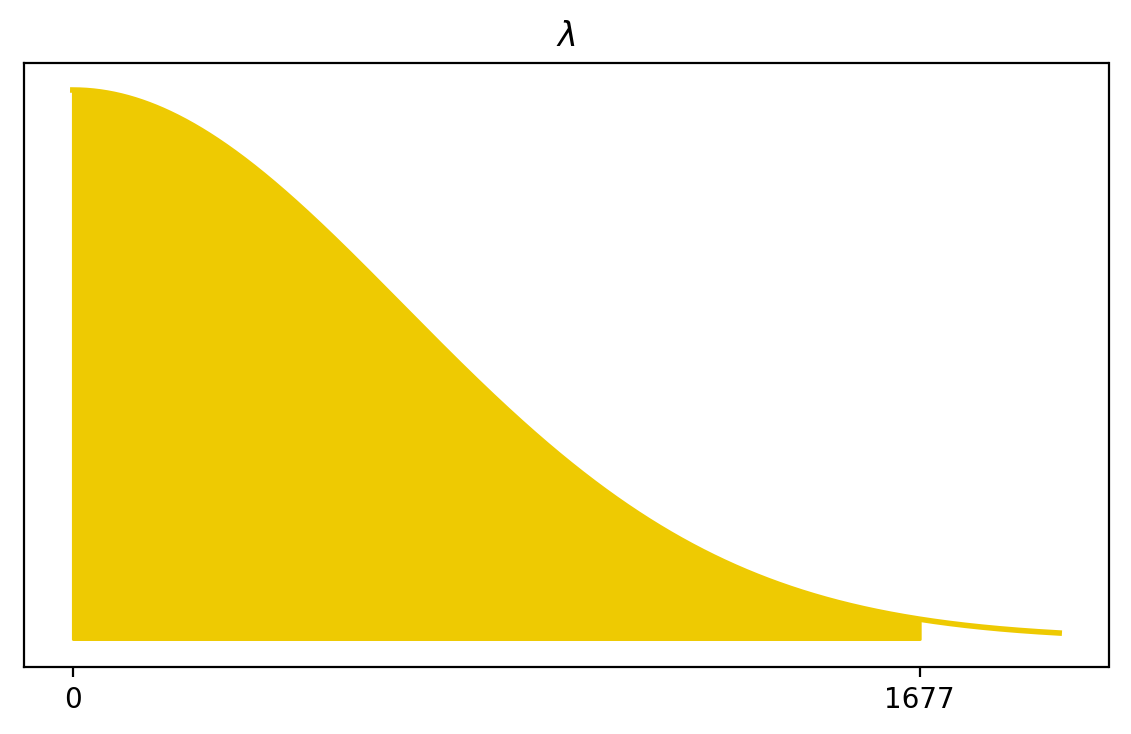

In [8]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,lam_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color=dark,linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,lam_ub[0]])
ax2.set_title(r'$\lambda$')
plt.show()

In [9]:
with open('stan/prior_sym.stan', 'r') as file:
    print(file.read())
model_prior=stan_utility.compile_model('stan/prior_sym.stan')

data {
  int M;//number of years analyzed
  real sigma;
}


generated quantities {
  real lambda=fabs(normal_rng(0,sigma));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}
Using cached StanModel


In [10]:
R=1000
sim_uf=model_prior.sampling(data={'M':1, 'sigma':sigma},
                            algorithm="Fixed_param",
                            iter=R,
                            warmup=0,
                            chains=1, 
                            refresh=R,
                            seed=5062020)

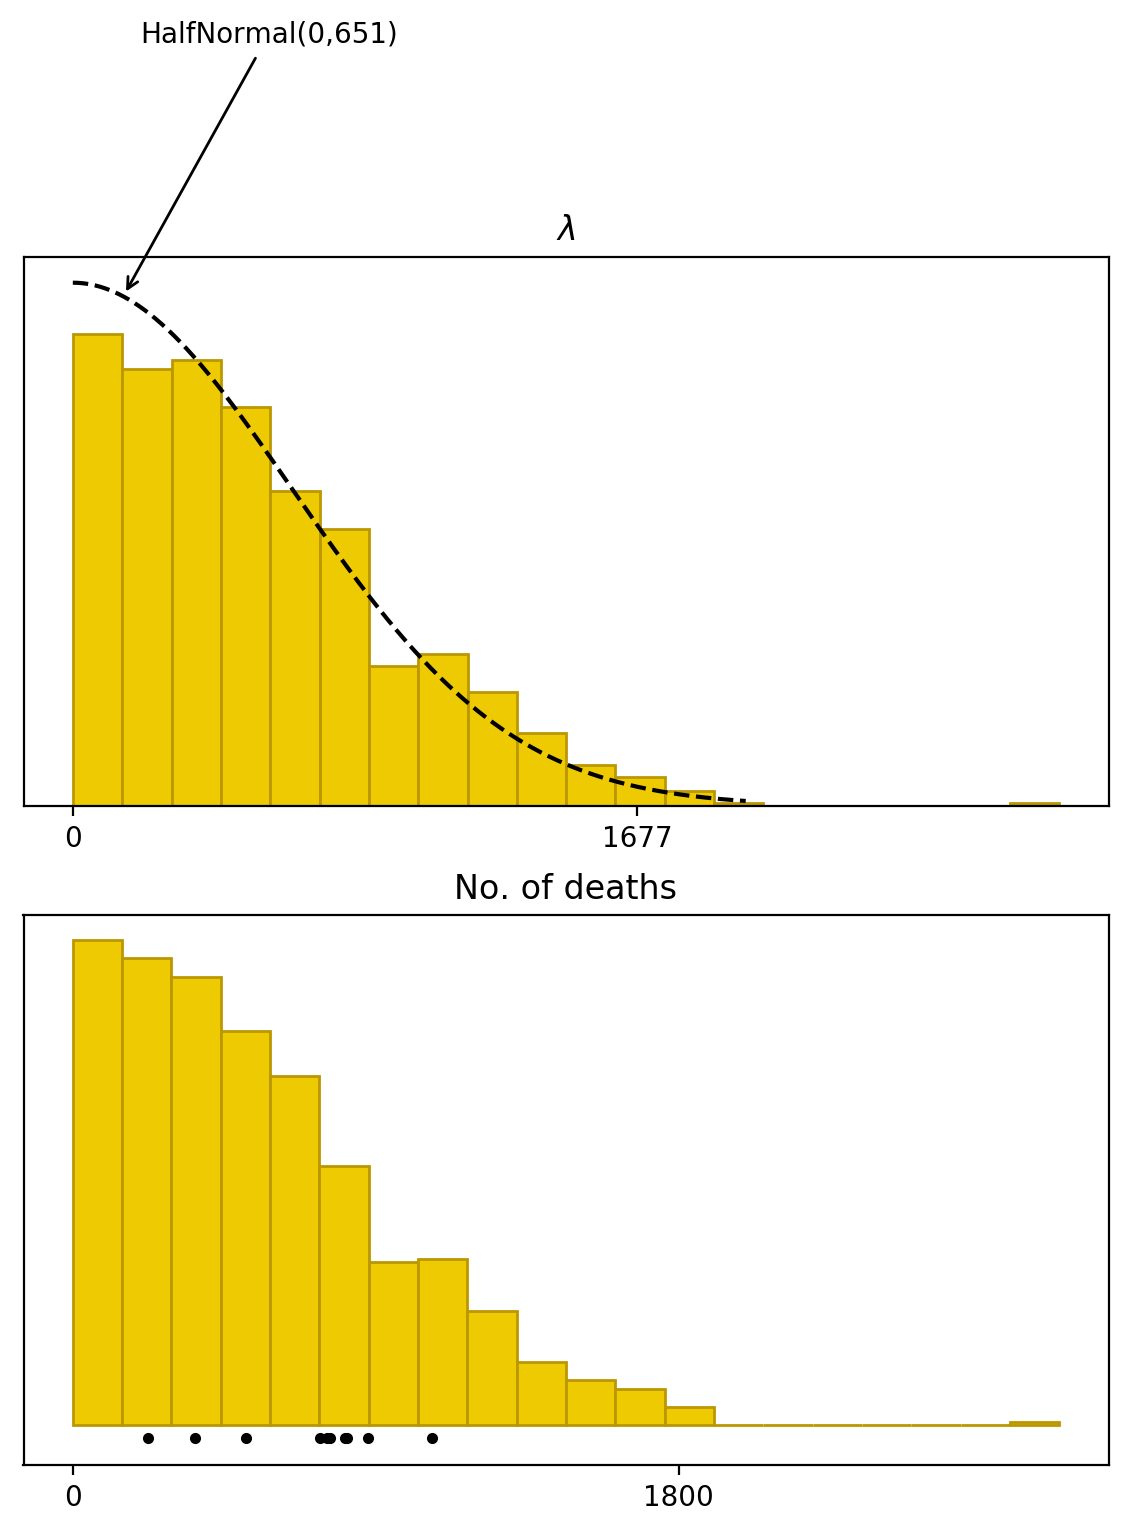

In [11]:
params=sim_uf.extract()
theta=params['lambda']
y_sim=params['y_sim']

fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,2000,2000)
ax1.set_xticks([0,lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(150,0,sigma)
ax1.annotate('HalfNormal(0,'+str(np.int(sigma))+')',xy=(150,arr_y_loc),xytext=(200,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax2=axes[1]
ax2.hist(y_sim.flatten(),color=dark,edgecolor=dark_highlight,density=True,bins=20,zorder=1)
ax2.scatter(dead,0.00003*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,1800])
ax2.set_yticks([])

ax2.set_title('No. of deaths')
plt.show()

In [12]:
with open('stan/post_inf.stan', 'r') as file:
    print(file.read())
model=stan_utility.compile_model('stan/post_inf.stan')

data {
  int M;//number of years analyzed
  int y[M];//number of deaths 
  real sigma;
}
parameters {
  real<lower=0>lambda;
}
model {
  lambda ~ normal(0,sigma);
  for (k in 1:M) {
    y[k] ~ poisson(lambda);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}

Using cached StanModel


In [13]:
data = dict(M = len(Airline_data),
            y = Airline_data['Passenger deaths'], 
           sigma = sigma)
fit = model.sampling(data=data, seed=5062020)

params=fit.extract()
lam=params['lambda']
y_sim=params['y_sim']

In [14]:
mean_lam = np.mean(lam)
cinf_lam = az.hpd(lam,0.89)

hpd_width=cinf_lam[1]-cinf_lam[0]

In [15]:
print('Mean lambda : {:4.2f}'.format(mean_lam))
print('89% confidence interval: [',*['{:4.2f}'.format(k) for k in cinf_lam],']')

Mean lambda : 691.79
89% confidence interval: [ 678.15 704.82 ]


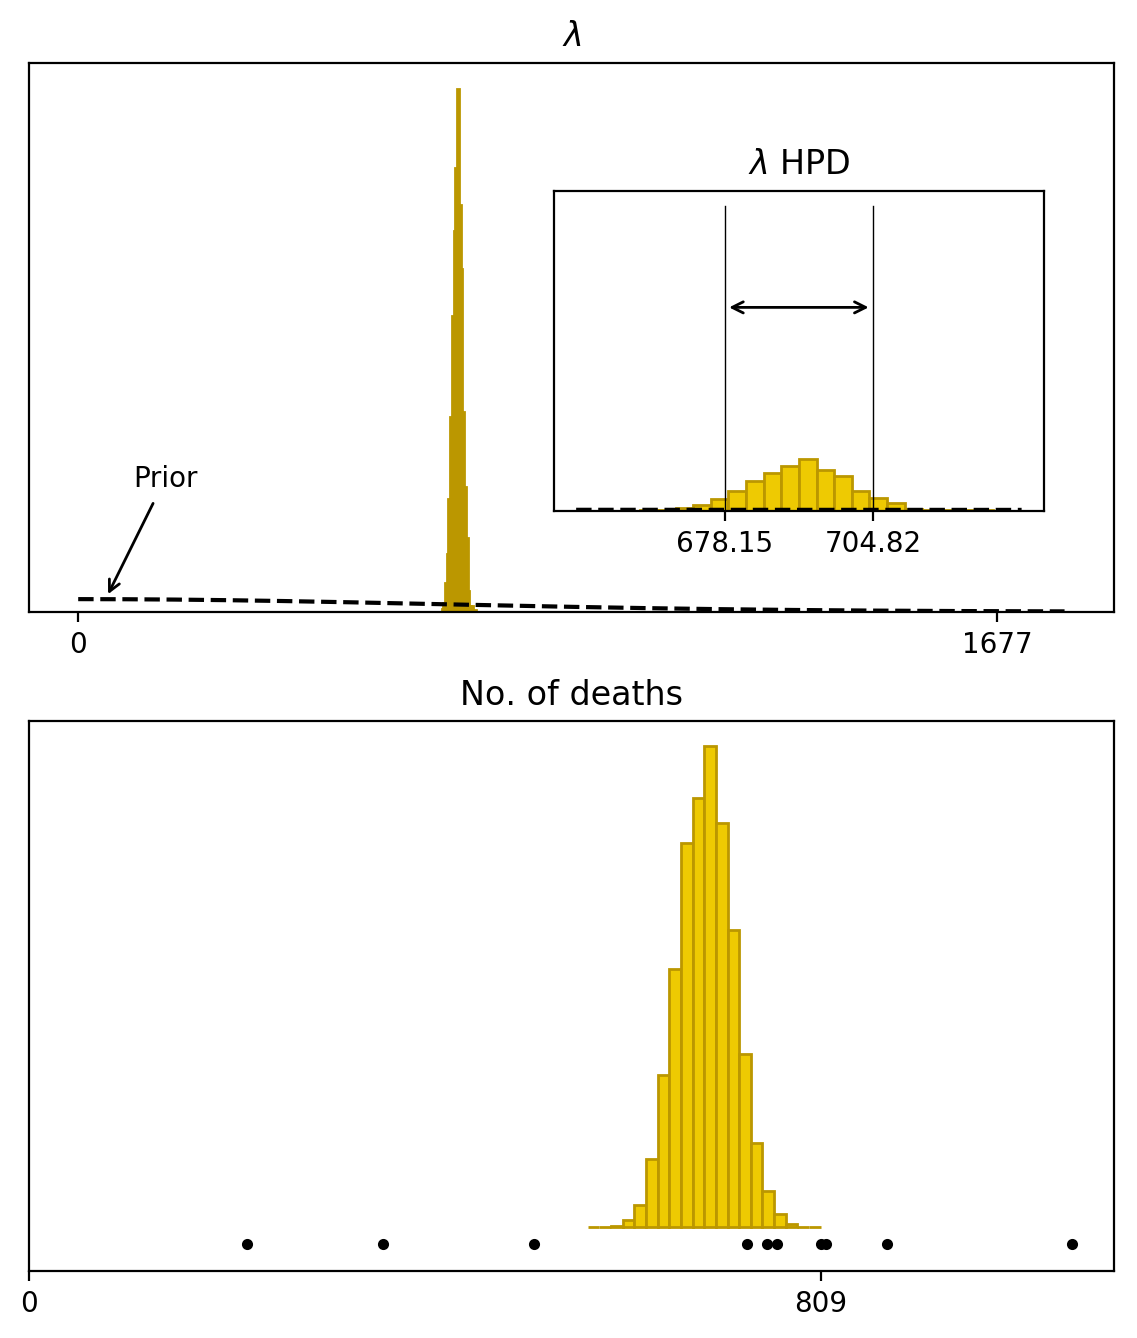

In [16]:
fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(lam,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1800,1000)

ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(50,0,sigma)
ax1.annotate('Prior',xy=(50,arr_y_loc),xytext=(100,10*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax1.set_xticks([0,lam_ub[0]])

ax1.set_yticks([])
ax1.set_title(r'$\lambda$')

ax_sm=plt.axes([0.5,0.6,0.35,0.2])
x_sm=np.linspace(cinf_lam[0]-hpd_width,cinf_lam[1]+hpd_width,200)
ax_sm.hist(lam,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')

ax_sm.annotate(s='', xy=(cinf_lam[0]-.2,0.2), xytext=(cinf_lam[1]+.2,0.2), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_lam[0],cinf_lam[0]],[0,0.3],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_lam[1],cinf_lam[1]],[0,0.3],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(np.round([cinf_lam[0],cinf_lam[1]],2))
ax_sm.set_yticks([])
ax_sm.set_title(r'$\lambda$ HPD')


ax2=axes[1]
ax2.hist(y_sim.flatten(),color=dark,edgecolor=dark_highlight,density=True,bins=20,zorder=1)
ax2.scatter(dead,0.0005*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,np.max(y_sim)])
ax2.set_yticks([])

ax2.set_title('No. of deaths')
plt.show()

In [17]:
median_y_sim = np.median(y_sim.flatten())
cinf_y_sim = az.hpd(y_sim.flatten(),0.89)

print('Median of predicted deaths =',median_y_sim)
print('Confidence interval = [',*cinf_y_sim,']')

Median of predicted deaths = 692.0
Confidence interval = [ 644.0 732.0 ]


#### In 1986 there were 546 passenger deaths. This is outside model's confidence interval

# Version 2 - constant intesity, rate depends on mileage

We still assume that having  big plane crash with 150 casualties every month would be very improbable. Our previous argument, can be still valid, however in order to compute the bound we will use $\lambda=\theta\cdot\bar{n}$, with $\bar{n}$ being mean of miles flown. This gives us condition
$$\theta\cdot\bar{n}+3\sqrt{\theta\cdot\bar{n}}\approx1800$$

We need to assign the prior for $\theta$ that would have probability of smaller $\lambda$ equal 99%.

In [18]:
mean_miles=np.mean(Airline_data['Miles flown [100 mln miles]'])
root_of_theta=np.polynomial.polynomial.polyroots([-1800/mean_miles,3./np.sqrt(mean_miles),1.])
theta_ub=(root_of_theta[root_of_lam>0]**2)
print('theta upper bound','{:4.3f}'.format(theta_ub[0]))

theta upper bound 0.293


In [19]:
data=dict(y_guess=np.array([np.log(0.1)]),theta=np.array(theta_ub))
tuned2 = tuning2.sampling(data=data,
                          seed=5062020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = (tuned2.extract()['sigma'][0])
print('sigma =','{:4.3f}'.format(sigma))

sigma = 0.114


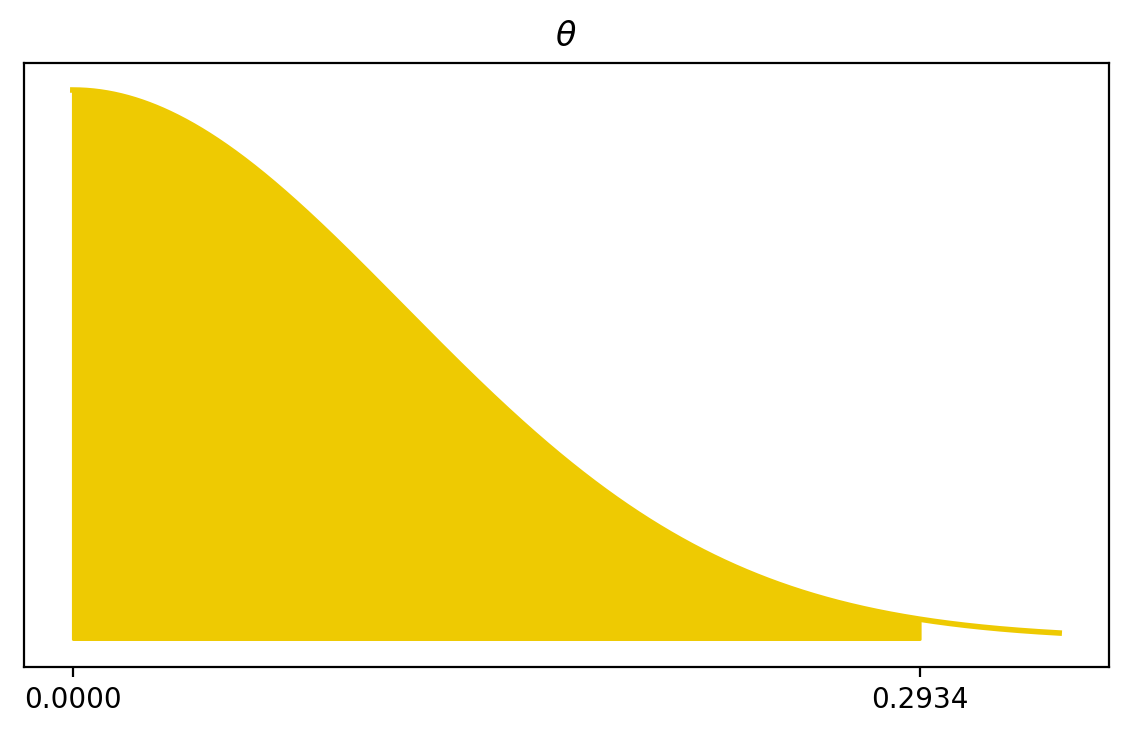

In [20]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,theta_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color=dark,linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,theta_ub[0]])
ax2.set_title(r'$\theta$')
plt.show()

In [21]:
with open('stan/prior_sym2.stan', 'r') as file:
    print(file.read())
model_prior=stan_utility.compile_model('stan/prior_sym2.stan')

data {
  int M;//number of years analyzed
  vector[M] miles; //number of miles flown each year
  real sigma;
}


generated quantities {
  real theta=fabs(normal_rng(0,sigma));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(theta*miles[k]);
  }
}
Using cached StanModel


In [22]:
R=1000
data_prior=dict(M=len(Airline_data),miles=Airline_data['Miles flown [100 mln miles]'].to_numpy(), 
           sigma = sigma)
sim_uf=model_prior.sampling(data=data_prior,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                     seed=5062020)

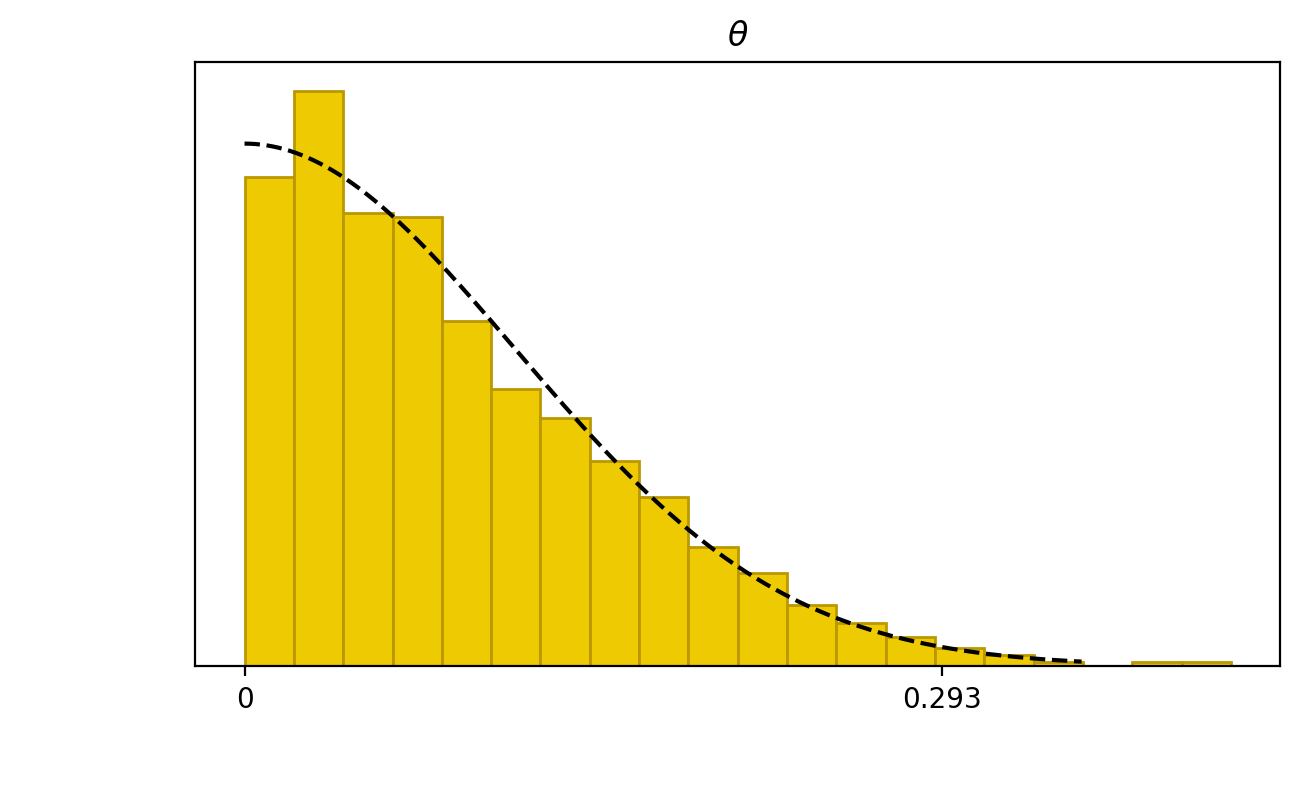

In [23]:
params=sim_uf.extract()
theta=params['theta']
#y_sim=params['y_sim']

fig, axes = plt.subplots(1, 1,figsize=(7, 4))
ax1=axes
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(1,0,sigma)
ax1.annotate('HalfNormal(0,'+'{:4.3f}'.format(sigma)+')',xy=(1,arr_y_loc),xytext=(1,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})
plt.show()

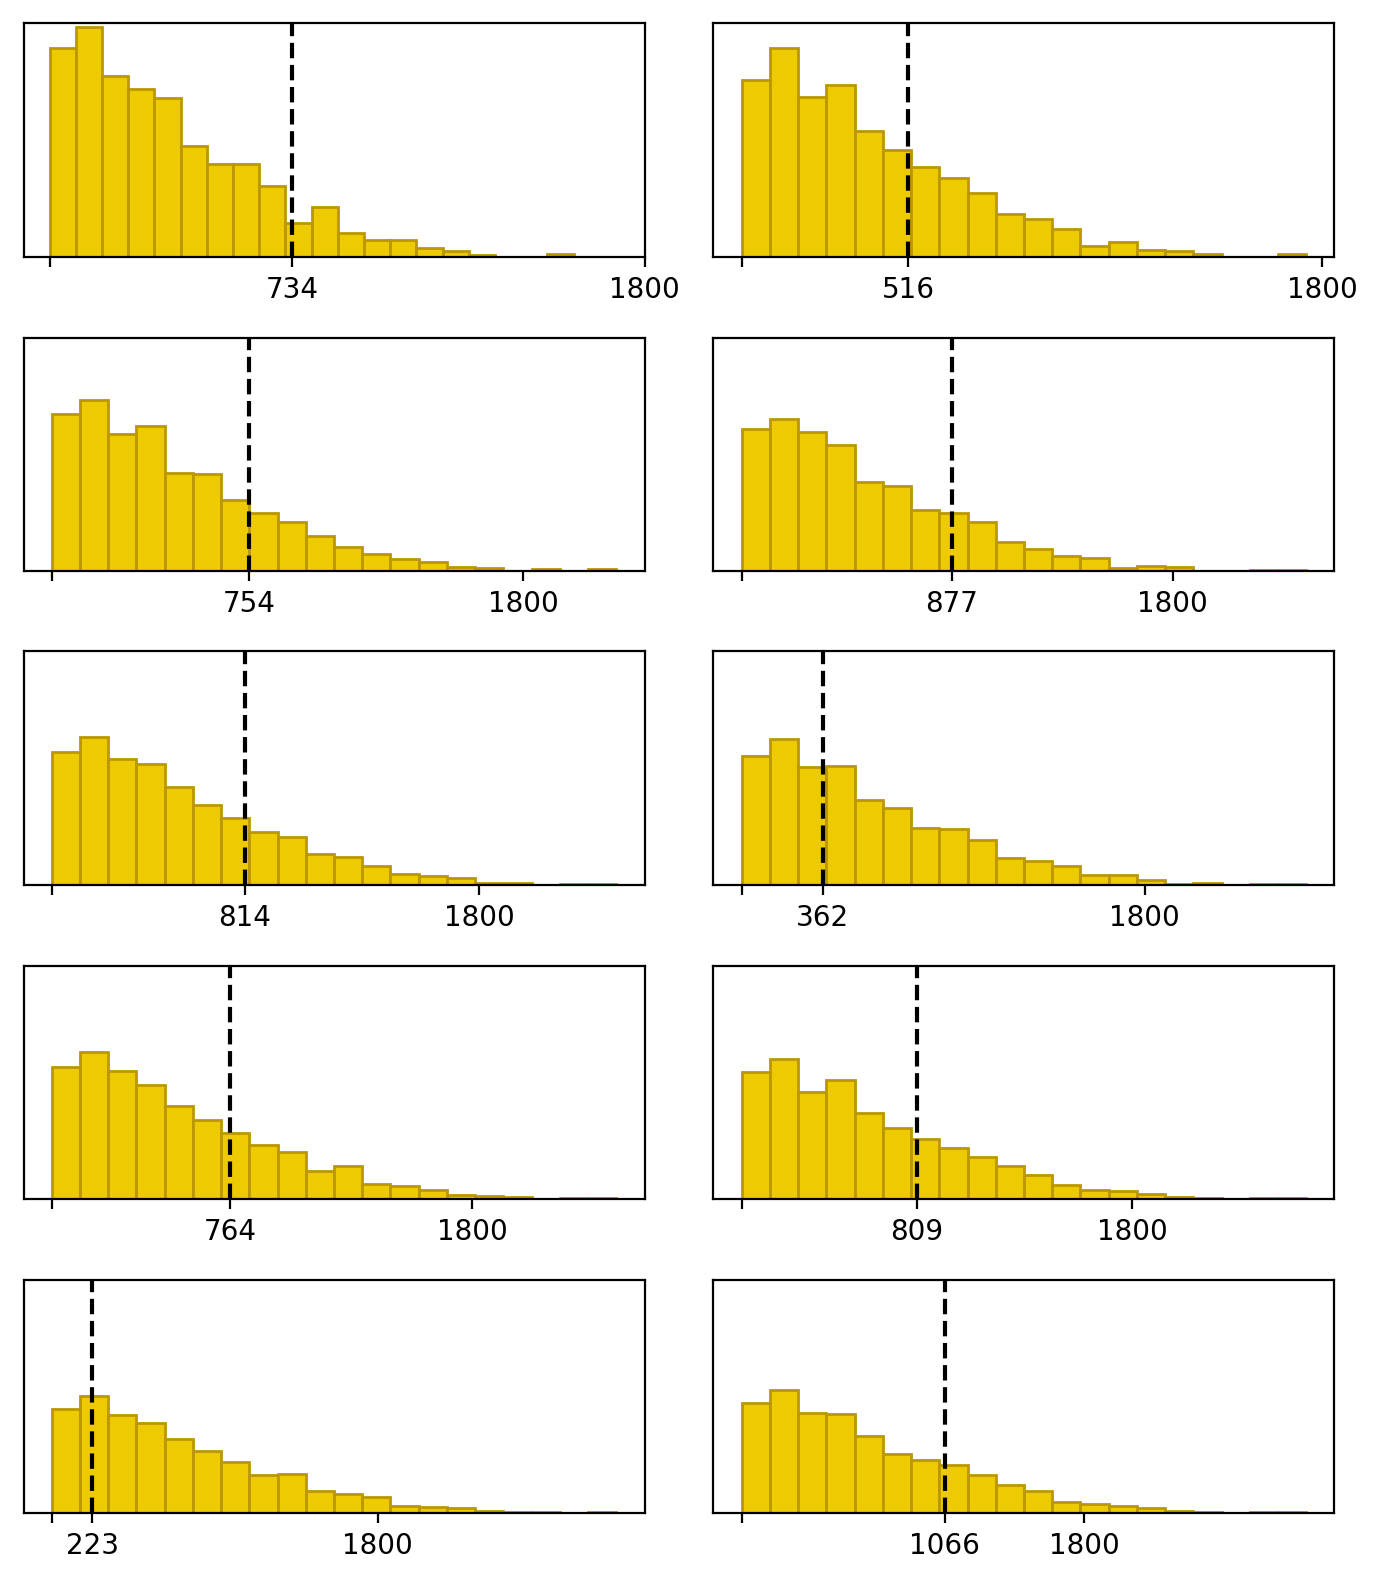

In [24]:
y_sim=params['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    tv=Airline_data['Passenger deaths'].iloc[k]
    ax.plot([tv,tv],[0,0.02],linestyle='--',color='black')
    ax.set_yticks([])
    ax.set_xticks([0,tv,1800])
    ax.set_xticklabels(['',tv,1800])
    ax.set_ylim([0,0.002])

fig.tight_layout()

plt.show()

In [25]:
with open('stan/post_inf2.stan', 'r') as file:
    print(file.read())
model_miles=stan_utility.compile_model('stan/post_inf2.stan')

data {
  int M;//number of years analyzed
  vector[M] miles; //number of miles flown each year
  int y[M];//number of fatal accidents
  real sigma;
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0,sigma);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(miles[k]*theta);
  }
}

Using cached StanModel


In [26]:
data = dict(M = len(Airline_data),
            miles = Airline_data['Miles flown [100 mln miles]'],
            y = Airline_data['Passenger deaths'],
           sigma = sigma)
fit = model_miles.sampling(data=data, seed=8062020)

params_miles=fit.extract()
theta=params_miles['theta']
y_sim=params_miles['y_sim']

In [27]:
mean_theta = np.mean(theta)
cinf_theta = az.hpd(theta,0.89)
hpd_width=cinf_theta[1]-cinf_theta[0]

In [28]:
print('Mean theta : {:5.4f}'.format(mean_theta))
print('89% confidence interval: [',*['{:5.4f}'.format(k) for k in cinf_theta],']')

Mean theta : 0.1210
89% confidence interval: [ 0.1188 0.1233 ]


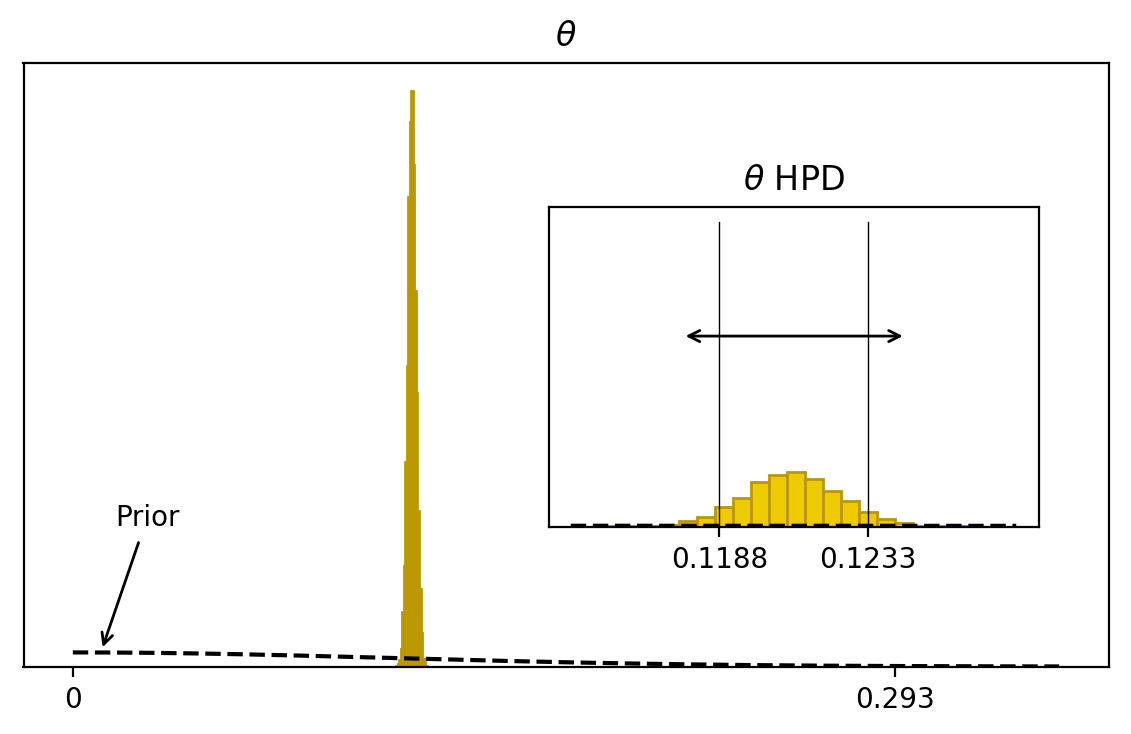

In [29]:
fig, axes = plt.subplots(1, 1,figsize=(7, 4))
ax1=axes
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(0.01,0,sigma)
ax1.annotate('Prior',xy=(0.01,arr_y_loc),xytext=(0.015,10*arr_y_loc),arrowprops={'arrowstyle':'->'})

ax_sm=plt.axes([0.5,0.3,0.35,0.4])
x_sm=np.linspace(cinf_theta[0]-hpd_width,cinf_theta[1]+hpd_width,200)
ax_sm.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(0.99*cinf_theta[0],1000), xytext=(1.01*cinf_theta[1],1000), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_theta[0],cinf_theta[0]],[0,1600],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_theta[1],cinf_theta[1]],[0,1600],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(([cinf_theta[0],cinf_theta[1]]))
ax_sm.set_xticklabels(np.round([cinf_theta[0],cinf_theta[1]],4))

ax_sm.set_yticks([])
ax_sm.set_title(r'$\theta$ HPD')

plt.show()

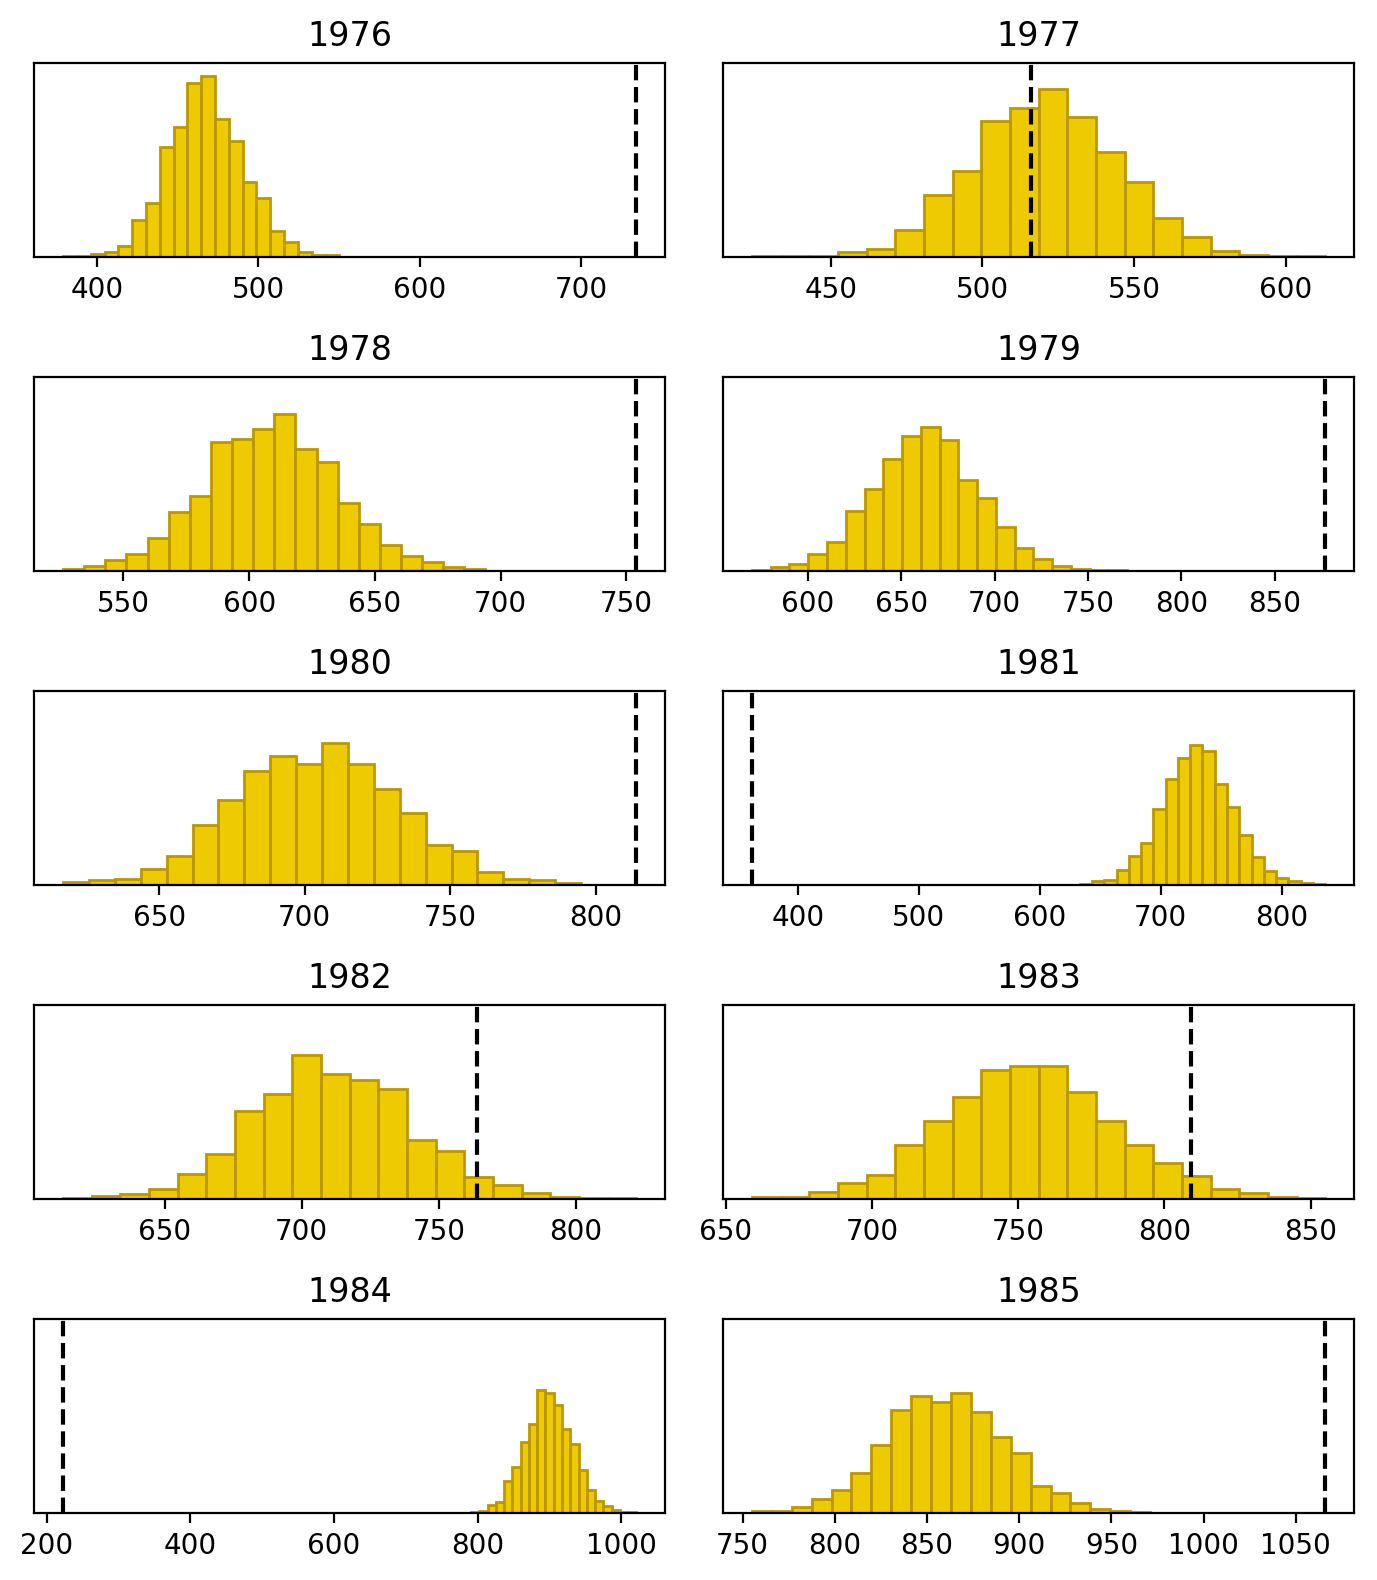

In [30]:
y_sim=params_miles['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title(Airline_data.index[k])
    tv=Airline_data['Passenger deaths'].iloc[k]
    ax.plot([tv,tv],[0,0.15],linestyle='--',color='black')
    ax.set_yticks([])
    ax.set_ylim([0,0.02])

fig.tight_layout()

plt.show()

#### Using model for prediction

In 1986, there were 22 fatal accidents, 546 passenger deaths, and a death rate of 0.06 per 100 million miles flown.


In [31]:
miles1986=546/0.06
print(np.round(miles1986))



9100.0


In [32]:
with open('stan/pred_1986.stan', 'r') as file:
    print(file.read())
model_pred=stan_utility.compile_model('stan/pred_1986.stan')

data {
  int M;//number of years analyzed
  vector[M] miles; //number of miles flown each year
  int y[M];//number of fatal accidents
  real sigma;
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0,sigma);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_1986 = poisson_rng(9100*theta);
}

Using cached StanModel


In [33]:
data = dict(M = len(Airline_data),
            miles = Airline_data['Miles flown [100 mln miles]'],
            y = Airline_data['Passenger deaths'],
            sigma=sigma)
fit = model_pred.sampling(data=data, seed=8052020)

y_pred=fit.extract()['y_1986']

In [34]:
median_y_1986 = np.median(y_pred)
cinf_y_1986 = az.hpd(y_pred,0.89)

print('Median of predicted accidents =',median_y_1986)
print('Confidence interval = [',*cinf_y_1986,']')

Median of predicted accidents = 1101.0
Confidence interval = [ 1044.0 1158.0 ]


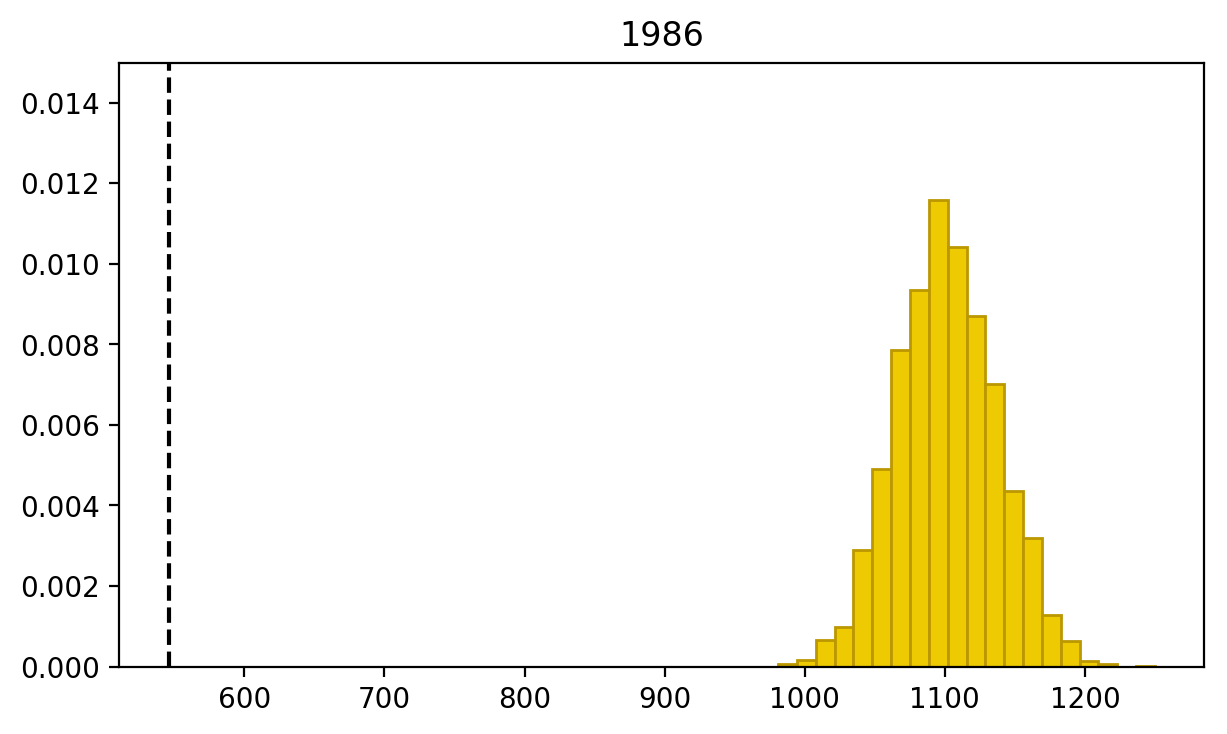

In [36]:
y_sim=params['y_sim']
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(y_pred,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax.set_title('1986')
tv = 546
ax.plot([tv,tv],[0,0.07],linestyle='--',color='black')

ax.set_ylim([0,0.015])


plt.show()

## Actual values are much smaller than predicted.


In [43]:
new_row = { 'Fatal accidents':22, 'Passenger deaths':546, 'Death rate':0.06, 'Miles flown [100 mln miles]':9100}
#append row to the dataframe
Airline_data = Airline_data.append(new_row, ignore_index=True)


In [44]:
Airline_data

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
0,24.0,734.0,0.19,3863.0
1,25.0,516.0,0.12,4300.0
2,31.0,754.0,0.15,5027.0
3,31.0,877.0,0.16,5481.0
4,22.0,814.0,0.14,5814.0
5,21.0,362.0,0.06,6033.0
6,26.0,764.0,0.13,5877.0
7,20.0,809.0,0.13,6223.0
8,16.0,223.0,0.03,7433.0
9,22.0,1066.0,0.15,7107.0
